# < 나의 첫 번째 캐글 경진대회, 무작정 따라해보기 >

### ■ Intro

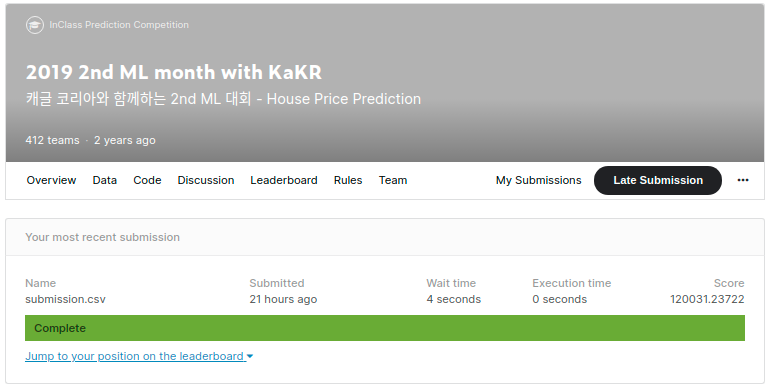

- 노드를 따라가며 진행한 첫 결과 제출 점수는 120031점이다.

- 지금 부터 이 점수를 110000점 이하로 낮춰야한다.

### ■ Step1 라이브러리 import & 데이터 load

**1-1 matplotlib 시각화 세팅**

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**1-2 필요한 라이브러리 import**

In [102]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


**1-3 데이터 load**

In [103]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


### ■ Step2 데이터 확인 및 전처리

**2-1 train 데이터 확인**

In [104]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


**2-2 date 컬럼 전처리**

In [105]:
# date를 보기 좋게 앞에서 6자리까지만 나오게 처리한다.

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


**2-3 학습 데이터 라벨 제거**

In [106]:
# price는 라벨(정답)이므로 제거한다.

y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


**2-4 id 컬럼 삭제**

In [107]:
# 불필요한 id 컬럼을 삭제한다.

del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


**2-5 test 데이터 전처리**

In [108]:
# test 데이터 역시 train 데이터 처럼 처리한다.

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

test_id = test['id']

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


**2-6 y 데이터(라벨) 확인**

In [109]:
# 라벨 값을 확인해본다.

y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

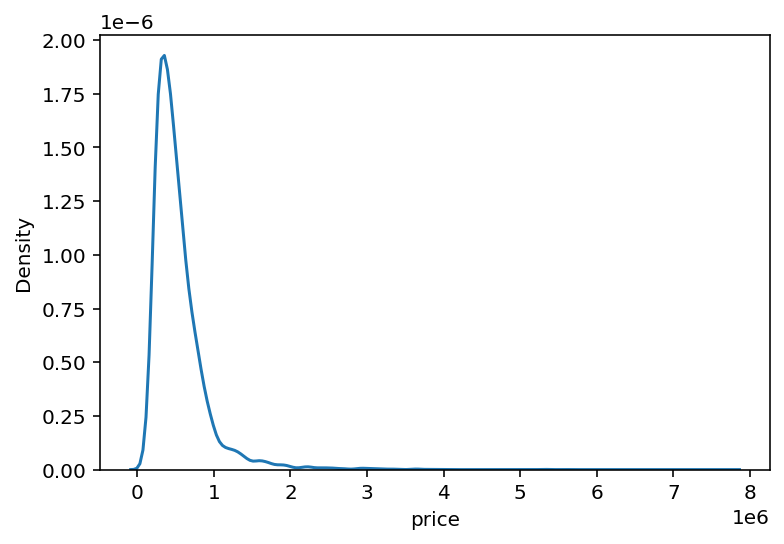

In [110]:
# 라벨 값을 시각화 해 본다. : 한 쪽으로 치우쳐져 있다.

sns.kdeplot(y)
plt.show()

**2-7 y 데이터(라벨) 로그 변환 및 확인**

In [111]:
# 치우쳐진 라벨 값을 로그 변환 한다.

y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

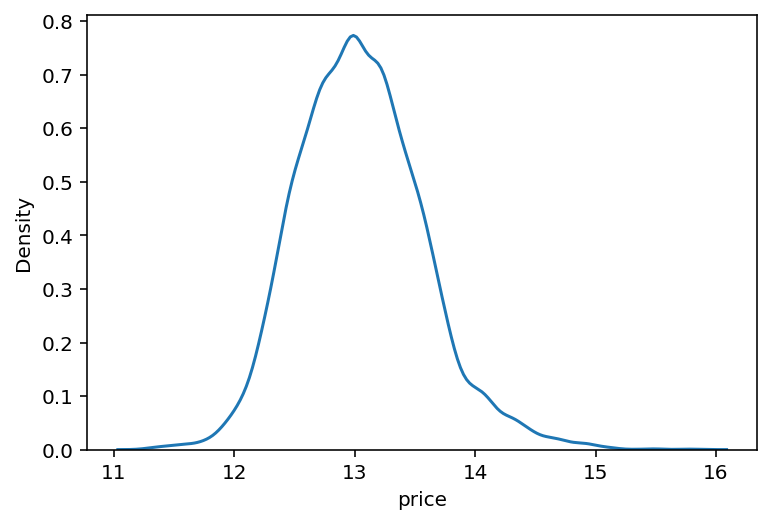

In [112]:
# 로그 변환된 라벨 값을 시각화 한다. : 정규분포에 가깝게 되었다.

sns.kdeplot(y)
plt.show()

**2-8 전체 데이터 자료형 확인**

In [113]:
# 학습 데이터 전체 정보를 살펴본다.

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

### ■ Step3 다양한 실험을 위해 함수 만들기

**3-1 필요한 라이브러리 import**

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('얍💢')

얍💢


**3-2 RMSE 계산 함수 만들기**

In [115]:
# 캐글에서 평가지표인 RMSE를 계산하는 함수를 만들어 쓴다.

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


**3-3 모델 불러오기**

In [116]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=2021

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


**3-4 여러 모델 학습 및 예측 함수 만들기**

In [117]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
        
        # train, test 데이터셋 분리 - random_state 고정
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        
        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # data frame 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

**3-5 함수 실행하기**

In [118]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,137616.546062
RandomForestRegressor,136497.215502
LGBMRegressor,128291.753330
XGBRegressor,126848.451359


### ■ Step4 GridSearchCV로 하이퍼파라미터 튜닝하기 : XGBRegressor

**4-1 GridSearchCV import**

In [119]:
from sklearn.model_selection import GridSearchCV

**4-2 GridSearchCV 함수 만들기**

In [120]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, 
                              param_grid=param_grid, 
                              scoring='neg_mean_squared_error',
                              cv=5, 
                              verbose=verbose, 
                              n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

**4-3 XGBMRegressor 하이퍼파라미터 찾기**

In [66]:
# 파라미터 그리드를 아래와 같이 설정하고 RMSLE값이 가장 낮은 파라미터 조합을 찾는다.

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model2 = XGBRegressor(random_state=random_state)
my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  5.1min finished


,max_depth,n_estimators,score,RMSLE
2,10,50,-0.030349,0.174210
3,10,100,-0.030470,0.174557
1,1,100,-0.043046,0.207475
0,1,50,-0.048745,0.220782


- 가장 좋은 하이퍼파라미터 조합은 `max_depth=10`, `n_estimators=50`으로 확인!

**4-4 모델 학습 및 결과 저장 함수 만들기**

In [122]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)  # 로그 값을 원래 값으로 되돌린다.
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction # 예측값을 price 컬럼에 넣는다.
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

**4-5 하이퍼파라미터 튜닝 모델로 결과 예측 및 저장**

In [67]:
model2 = XGBRegressor(max_depth=10, n_estimators=50, random_state=random_state)

save_submission(model2, train, y, test, 'xgb', rmsle='0.0174210')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_xgb_RMSLE_0.0174210.csv saved!


**4-6 결과 제출 및 점수 확인**

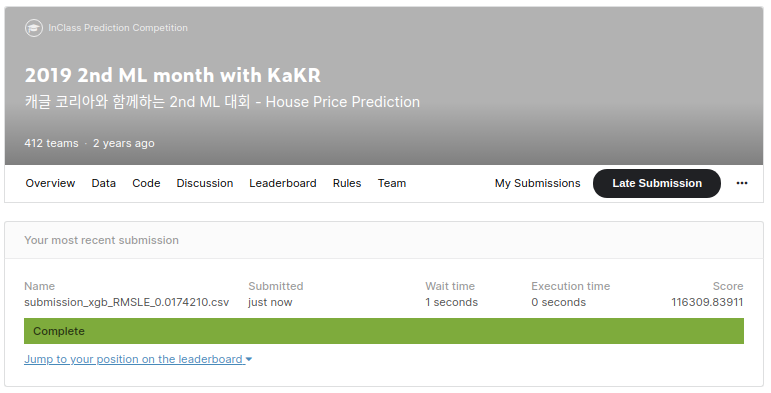

- 점수는 `116309점`으로 11만점 이하로 내려가지 못했다.

- 점수를 더 낮춰야한다..

### ■ Step5 하이퍼파라미터 튜닝하기 : GradientBoostingRegressor

**5-1 GradientBoostingRegressor 하이퍼파라미터 찾기**

In [68]:
# 파라미터 그리드를 아래와 같이 설정하고 RMSLE값이 가장 낮은 파라미터 조합을 찾는다.

param_grid = {
    'n_estimators': [50, 75, 100],
    'max_depth': [1, 5, 10],
    'learning_rate': [0.001, 0.01, 0.1]
}

model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   41.8s
[Parallel(n_jobs=5)]: Done 135 out of 135 | elapsed:  4.2min finished


,learning_rate,max_depth,n_estimators,score,RMSLE
23,0.100,5,100,-0.028579,0.169052
22,0.100,5,75,-0.029570,0.171958
26,0.100,10,100,-0.029574,0.171971
25,0.100,10,75,-0.029639,0.172161
24,0.100,10,50,-0.030017,0.173254
21,0.100,5,50,-0.031356,0.177076
20,0.100,1,100,-0.055036,0.234597
19,0.100,1,75,-0.061509,0.248010
17,0.010,10,100,-0.068825,0.262344
18,0.100,1,50,-0.073253,0.270653


- 가장 좋은 하이퍼파라미터 조합은 `learning_rate=0.1`, `max_depth=5`, `n_estimators=100`으로 확인!

**5-2 하이퍼파라미터 튜닝 모델로 결과 예측 및 저장**

In [70]:
model3 = GradientBoostingRegressor(max_depth=5, n_estimators=100, learning_rate=0.1, random_state=random_state)

save_submission(model3, train, y, test, 'gb', rmsle='0.169052')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_gb_RMSLE_0.169052.csv saved!


**5-3 결과 제출 및 점수 확인**

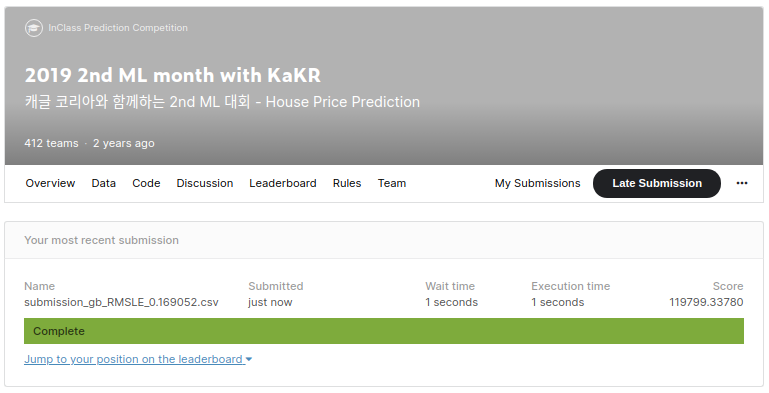

- 점수는 `119799점`으로 더 안좋아 졌다.. 

- 다시 점수를 낮춰야한다....


### ■ Step6 하이퍼파라미터 튜닝하기 : LGBRegressor

**6-1 LGBMRegressor 하이퍼파라미터 찾기**

In [126]:
# 파라미터 그리드를 아래와 같이 설정하고 RMSLE값이 가장 낮은 파라미터 조합을 찾는다.

param_grid = {
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   13.1s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 320 out of 320 | elapsed:  2.4min finished


,learning_rate,max_depth,n_estimators,score,RMSLE
62,0.1000,20,300,-0.026091,0.161527
55,0.1000,10,400,-0.026121,0.161619
54,0.1000,10,300,-0.026127,0.161640
53,0.1000,10,200,-0.026188,0.161828
63,0.1000,20,400,-0.026206,0.161883
...,...,...,...,...,...
1,0.0001,5,200,-0.270236,0.519842
8,0.0001,15,100,-0.274318,0.523753
12,0.0001,20,100,-0.274318,0.523753
4,0.0001,10,100,-0.274318,0.523753


- 가장 좋은 하이퍼파라미터 조합은 `learning_rate=0.1`, `max_depth=20`, `n_estimators=300`으로 확인!

**6-2 하이퍼파라미터 튜닝 모델로 결과 예측 및 저장**

In [127]:
model = LGBMRegressor(learning_rate=0.1, max_depth=20, n_estimators=300, random_state=random_state)

save_submission(model, train, y, test, 'lgbm', rmsle='0.161527')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161527.csv saved!


**6-3 결과 제출 및 점수 확인**

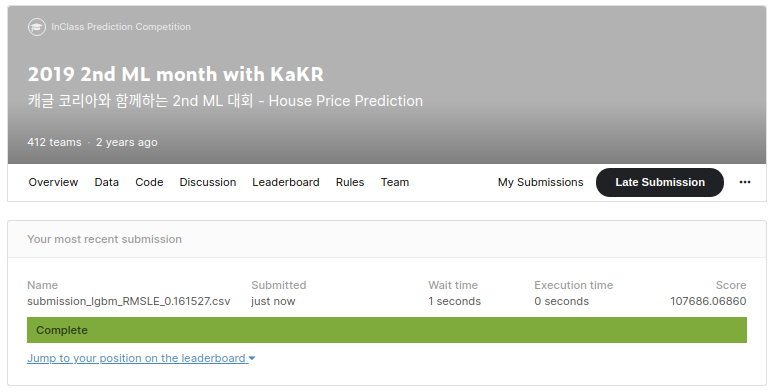

- 점수는 `107686점`으로 11만점 이하로 내려왔다..!

- 드디어 성공..

### ■ (번외) 튜닝된 xgbr, gbr, lgbr로 Average Blending

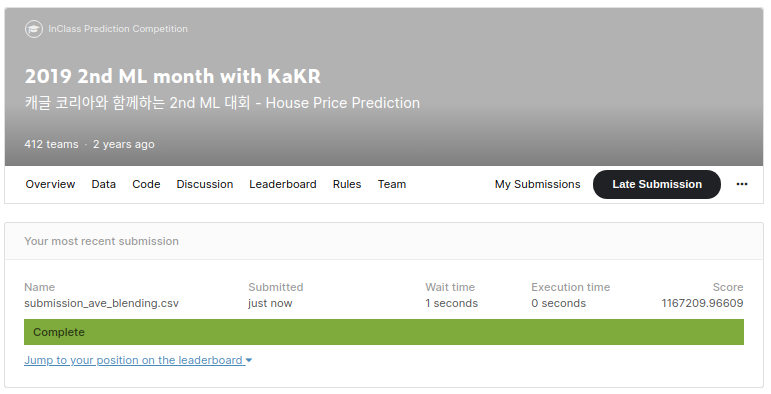

- 점수가 다시 11만점 대로 올라가버렸다.. 그래서, 결과만 캡쳐해두고 코딩 과정은 지웠다..

- lgbr의 점수는 10만점 대이지만, xgbr과 gbr 점수가 11만점 이상이라 평균적으로 11만점 이상 나온 것 같다..

### ■ 정리 및 회고

**1. 과정 정리**

- 노드 진행에 따른 Average Blending : **score 120031**
    
- Grid Search로 XGBRegressor 하이퍼파라미터 튜닝 : **score 116309**
    
- Grid Search로 GradientBoostingRegressor 하이퍼파라미터 튜닝 : **score 119799**
    
- Grid Search로 LGBRegressor 하이퍼파라미터 튜닝 : **`score 107686`**
    
- (번외) 튜닝된 xgbr, gbr, lgbr로 Average Blending : **score 1167209**

**2. 좋았던 점**

- `EX2 scikit-learn toy datasets 다루기`를 진행하면서 **GridSearchCV**를 알게 되었으나 적용해보지는 못했는데, 이번 노드를 통해 여러번 사용하게 되어 하이퍼파라미터 튜닝을 이해하는데 많은 도움이 되었다.

**3.아쉬운점**

- 노드 길이가 전체적으로 길어 흐름과 과정을 이해하느라 상당한 시간이 소요되, 데이터를 깊게 탐색하는 EDA 과정을 많이 시도해보지 못했다. 추후에 `EDA` 분야에 대해서 보다 깊이 알아보고 싶다.

- 아직 모델 자체와 모델별 하이퍼파라미터에 대한 이해가 많이 부족하다. 다양한 모델들과 하이퍼파라미터에 대해 시간을 갖고 하나 하나 살펴봐야하는데 그러지 못해 아쉽다. 아직은 감으로 하이퍼 파라미터를 몇 가지 입력하여 gridsearch를 진행했지만 보다 더 효과적인 방법으로 튜닝해보고 싶다.